In [40]:
# 1) 라이브러리
import os, re, random, math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils

SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

In [41]:
# 2) 데이터 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"

In [42]:
# 3) WISDM 파서(정규식)
def load_wisdm_regex(path):
    pat = re.compile(
        r'^\s*(\d+)\s*,\s*([A-Za-z_]+)\s*,\s*(\d+)\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*;?\s*$'
    )
    rows, skipped = [], 0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.match(line)
            if not m: skipped += 1; continue
            rows.append((
                int(m.group(1)), m.group(2), int(m.group(3)),
                float(m.group(4)), float(m.group(5)), float(m.group(6))
            ))
    df = pd.DataFrame(rows, columns=["user","activity","timestamp","x","y","z"])
    print(f"[INFO] Parsed {len(df):,} rows. Skipped {skipped:,} malformed lines.")
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

df = load_wisdm_regex(DATA_PATH)
print(df.head(), df.shape)
print(df["activity"].value_counts())


[INFO] Parsed 1,086,465 rows. Skipped 11,745 malformed lines.
   user activity  timestamp    x    y    z
0    32  Jogging          0  0.0  0.0  0.0
1    32  Jogging          0  0.0  0.0  0.0
2    32  Jogging          0  0.0  0.0  0.0
3    32  Jogging          0  0.0  0.0  0.0
4    32  Jogging          0  0.0  0.0  0.0 (1086465, 6)
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


In [43]:
# 4) 라벨 인코딩
le = LabelEncoder()
df["label"] = le.fit_transform(df["activity"])
class_names = list(le.classes_)
print("Label mapping:", {cls: int(lab) for cls, lab in zip(class_names, le.transform(class_names))})

Label mapping: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}


In [44]:
# 5) 슬라이딩 윈도우(유저/액티비티 경계 보존)
feature_cols = ["x","y","z"]
WINDOW_SIZE = 200
STEP = 100

def _segment_one_run(sub_df, window_size, step, feature_cols, label_col, num_classes=None):
    data = sub_df[feature_cols].to_numpy(dtype=np.float32)   # (L, C)
    labels = sub_df[label_col].to_numpy()
    segs, labs = [], []
    L = len(sub_df)
    for start in range(0, L - window_size + 1, step):
        end = start + window_size
        segs.append(data[start:end])
        if (num_classes is not None) and np.issubdtype(labels.dtype, np.integer):
            labs.append(np.bincount(labels[start:end], minlength=num_classes).argmax())
        else:
            codes, uniques = pd.factorize(labels[start:end], sort=False)
            labs.append(uniques[np.bincount(codes).argmax()])
    return segs, labs

def create_windows(df, window_size=200, step=100, feature_cols=("x","y","z"), label_col="label", num_classes=None):
    feature_cols = list(feature_cols)
    segments, labels = [], []
    user_groups = df.groupby("user", sort=False) if "user" in df.columns else [(None, df)]
    for _, df_u in user_groups:
        change = df_u["activity"].ne(df_u["activity"].shift()).to_numpy()
        starts = np.flatnonzero(change) if change.any() else np.array([0], dtype=int)
        ends = np.r_[starts[1:], len(df_u)]
        for s, e in zip(starts, ends):
            sub = df_u.iloc[s:e]
            if len(sub) < window_size: continue
            segs, labs = _segment_one_run(sub, window_size, step, feature_cols, label_col, num_classes)
            segments.extend(segs); labels.extend(labs)
    X = np.array(segments, dtype=np.float32) if segments else np.empty((0, window_size, len(feature_cols)), np.float32)
    y = np.array(labels)
    return X, y


In [45]:
# 6) 유저 기준 분할
assert "user" in df.columns
train_users = set([u for u in np.unique(df["user"]) if u <= 27])
test_users  = set([u for u in np.unique(df["user"]) if u >= 28])

df_train_full = df[df["user"].isin(train_users)].copy()
df_test       = df[df["user"].isin(test_users)].copy()

# 검증 유저 홀드아웃
rng = np.random.default_rng(SEED)
train_user_list = sorted(list(train_users))
n_val_users = max(1, int(len(train_user_list)*0.2))
val_users = set(rng.choice(train_user_list, size=n_val_users, replace=False))
tr_users  = train_users - val_users

df_train = df_train_full[df_train_full["user"].isin(tr_users)].copy()
df_val   = df_train_full[df_train_full["user"].isin(val_users)].copy()

print("train users:", sorted(df_train["user"].unique()))
print("val   users:", sorted(df_val["user"].unique()))
print("test  users:", sorted(df_test["user"].unique()))

# train-only 스케일링 (xyz만)
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_val[feature_cols]   = scaler.transform(df_val[feature_cols])
df_test[feature_cols]  = scaler.transform(df_test[feature_cols])

# 세트별 윈도우링
n_cls = len(np.unique(df["label"]))
X_train, y_train = create_windows(df_train, WINDOW_SIZE, STEP, feature_cols, "label", n_cls)
X_val,   y_val   = create_windows(df_val,   WINDOW_SIZE, STEP, feature_cols, "label", n_cls)
X_test,  y_test  = create_windows(df_test,  WINDOW_SIZE, STEP, feature_cols, "label", n_cls)

num_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2])

y_train_cat = utils.to_categorical(y_train, num_classes)
y_val_cat   = utils.to_categorical(y_val,   num_classes)
y_test_cat  = utils.to_categorical(y_test,  num_classes)

print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


train users: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)]
val   users: [np.int64(3), np.int64(12), np.int64(17), np.int64(19), np.int64(27)]
test  users: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
X_train: (5939, 200, 3) X_val: (1596, 200, 3) X_test: (2679, 200, 3)


In [46]:
# 8) 3D 회전 + 노이즈/스케일 증강
def _rand_rot_matrix():
    a,b,c = np.random.uniform(0, 2*np.pi, size=3)
    Rx = np.array([[1,0,0],[0,np.cos(a),-np.sin(a)],[0,np.sin(a),np.cos(a)]], dtype=np.float32)
    Ry = np.array([[np.cos(b),0,np.sin(b)],[0,1,0],[-np.sin(b),0,np.cos(b)]], dtype=np.float32)
    Rz = np.array([[np.cos(c),-np.sin(c),0],[np.sin(c),np.cos(c),0],[0,0,1]], dtype=np.float32)
    return (Rz @ Ry @ Rx).astype(np.float32)

def rotate_subset(X, y, ratio=0.6, xyz_idx=(0,1,2)):
    n = len(X); m = int(n * ratio)
    idx = np.random.choice(n, size=m, replace=False)
    Xa = X[idx].copy(); ya = y[idx].copy()
    for i in range(m):
        R = _rand_rot_matrix()
        # Apply rotation to each time step
        for t in range(Xa.shape[1]):
            Xa[i, t, list(xyz_idx)] = Xa[i, t, list(xyz_idx)] @ R.T
    return Xa, ya

def jitter_scale(X, noise_std=0.01, scale_std=0.10):
    Xn = X + np.random.normal(0, noise_std, X.shape).astype(np.float32)
    s  = np.random.normal(1.0, scale_std, size=(X.shape[0],1,1)).astype(np.float32)
    return Xn * s

Xr, yr = rotate_subset(X_train, y_train, ratio=0.6, xyz_idx=(0,1,2))
Xj     = jitter_scale(Xr, noise_std=0.01, scale_std=0.10)

X_train = np.concatenate([X_train, Xr, Xj], axis=0)
y_train = np.concatenate([y_train, yr, yr], axis=0)

# 셔플, 원-핫 갱신
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]; y_train = y_train[perm]
y_train_cat = utils.to_categorical(y_train, num_classes)

print("After aug:", X_train.shape, np.bincount(y_train, minlength=num_classes))

After aug: (13065, 200, 3) [ 995 4307  702  488 1355 5218]


## TimeNorm
 - 한 윈도우(시계열 조각) 안에서, 채널별로 시간축 기준 평균을 0, 표준편차를 1로 맞춰 주는 정규화 레이어
- 사용자·부착 위치·센서 편차로 인한 도메인 갭 완화
- 학습 초반 val loss 튐 현상 감소, 일반화↑
- 배치 크기 변화에 덜 민감(추론 시 러닝 통계가 필요 없음)

In [47]:
# 9) 동적(TimeNorm) + 정적(창 평균) 결합 CNN — RepeatVector 사용
from tensorflow.keras import layers, models, regularizers

class TimeNorm(layers.Layer):
    def __init__(self, eps=1e-5, **kw):
        super().__init__(**kw); self.eps = eps
    def call(self, x):
        mu = tf.reduce_mean(x, axis=1, keepdims=True)     # (N,1,C)
        sd = tf.math.reduce_std(x, axis=1, keepdims=True) + self.eps
        return (x - mu) / sd

def build_cnn(input_shape, num_classes,
              label_smoothing=0.07, wd=1e-4, lr=1e-3):
    T, C = input_shape  # 윈도우 길이와 채널 수

    inp = layers.Input(shape=input_shape)

    # 동적 부분: 윈도우 내 정규화 (사용자/디바이스 차이 흡수)
    x_dyn = TimeNorm()(inp)                               # (N,T,C)

    # 정적 부분: 창 평균(기울기) -> 시간축으로 타일링
    mu_vec   = layers.GlobalAveragePooling1D()(inp)       # (N,C)
    mu_tiled = layers.RepeatVector(T)(mu_vec)             # (N,T,C)

    # 결합: (동적 C) + (정적 C) = (N,T,2C)
    x = layers.Concatenate(axis=-1)([x_dyn, mu_tiled])

    # 본체
    x = layers.Conv1D(64, 7, padding="same",
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x); x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Conv1D(128, 5, padding="same",
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x); x = layers.SpatialDropout1D(0.3)(x)

    x = layers.Conv1D(256, 3, padding="same",
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    gap = layers.GlobalAveragePooling1D()(x)
    gmp = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([gap, gmp])
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["accuracy"]
    )
    return model

# 모델 빌드
model = build_cnn(input_shape, num_classes)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 200, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ input_layer_8[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_norm_4         │ (None, 200, 3)    │          0 │ input_layer_8[0]… │
│ (TimeNorm)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 200, 3)    │          0 │ global_average_p… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 200, 6)    │          0 │ time_norm_4[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 200, 64)   │      2,752 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 200, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 100, 64)   │          0 │ re_lu_12[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_8 │ (None, 100, 64)   │          0 │ max_pooling1d_8[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 100, 128)  │     41,088 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 50, 128)   │          0 │ re_lu_13[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_9 │ (None, 50, 128)   │          0 │ max_pooling1d_9[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 50, 256)   │     98,560 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ re_lu_14[0][0]  

 Total params: 147,270 (575.27 KB)

 Trainable params: 146,374 (571.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [48]:
# #10 교체: 학습
EPOCHS = 40
BATCH_SIZE = 256

es  = callbacks.EarlyStopping(
    patience=8, restore_best_weights=True, monitor="val_loss"
)
ckpt = callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True, verbose=0
)

# class_weight는 기존 계산 유지
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[es, ckpt],
    verbose=1
)


Epoch 1/40
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.2628 - loss: 2.4959

52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 550ms/step - accuracy: 0.2646 - loss: 2.4811 - val_accuracy: 0.6573 - val_loss: 1.4547
Epoch 2/40
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.4421 - loss: 1.5421

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 551ms/step - accuracy: 0.4427 - loss: 1.5405 - val_accuracy: 0.6623 - val_loss: 1.2600
Epoch 3/40
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5202 - loss: 1.3821

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.5207 - loss: 1.3807 - val_accuracy: 0.6147 - val_loss: 1.2543
Epoch 4/40
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5697 - loss: 1.2482

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.5704 - loss: 1.2475 - val_accuracy: 0.7437 - val_loss: 1.1053
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.6289 - loss: 1.1687 - val_accuracy: 0.6967 - val_loss: 1.1435
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.6635 - loss: 1.1019 - val_accuracy: 0.6842 - val_loss: 1.1718
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.7102 - loss: 1.0323 - val_accuracy: 0.7036 - val_loss: 1.2102
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 536ms/step - accuracy: 0.7247 - loss: 1.0084 - val_accuracy: 0.7112 - val_loss: 1.1820
Epoch 9/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 556ms/step - accuracy: 0.7541 - loss: 0.9441 - val_accuracy: 0.7030 - val_loss: 1.2272
Epoch 10/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 554ms/step - accuracy: 0.7696 - loss: 0.9183 - val_accuracy: 0.7237 - val_loss: 1.1770
Epoch 11/40
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7880 - loss: 0.8902

52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 546ms/step - accuracy: 0.7880 - loss: 0.8903 - val_accuracy: 0.7306 - val_loss: 1.0898
Epoch 12/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.7972 - loss: 0.8822 - val_accuracy: 0.7218 - val_loss: 1.1343
Epoch 13/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.8122 - loss: 0.8522 - val_accuracy: 0.7187 - val_loss: 1.1793
Epoch 14/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.8174 - loss: 0.8382 - val_accuracy: 0.7237 - val_loss: 1.1695
Epoch 15/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - accuracy: 0.8276 - loss: 0.8043 - val_accuracy: 0.7180 - val_loss: 1.1965
Epoch 16/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 542ms/step - accuracy: 0.8328 - loss: 0.8029 - val_accuracy: 0.7256 - val_loss: 1.1529
Epoch 17/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 537ms/step - accuracy: 0.8474 - loss: 0.7831 - val_accuracy: 0.7187 - val_loss: 1.1837
Epoch 18/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.8482 - loss: 0.7673 - val_accuracy

In [49]:
# 11) 평가
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"[TEST] loss={test_loss:.4f} acc={test_acc:.4f}")

y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Macro F1:", round(f1_score(y_test, y_pred, average="macro"), 4),
      "/ Weighted F1:", round(f1_score(y_test, y_pred, average="weighted"), 4))

[TEST] loss=0.6322 acc=0.9257

=== Classification Report ===
              precision    recall  f1-score   support

  Downstairs       0.72      0.87      0.79       247
     Jogging       0.98      0.91      0.94       760
     Sitting       0.89      0.95      0.92       168
    Standing       0.86      0.95      0.90       150
    Upstairs       0.95      0.77      0.85       279
     Walking       0.95      0.99      0.97      1075

    accuracy                           0.93      2679
   macro avg       0.89      0.90      0.89      2679
weighted avg       0.93      0.93      0.93      2679

Macro F1: 0.8949 / Weighted F1: 0.9262


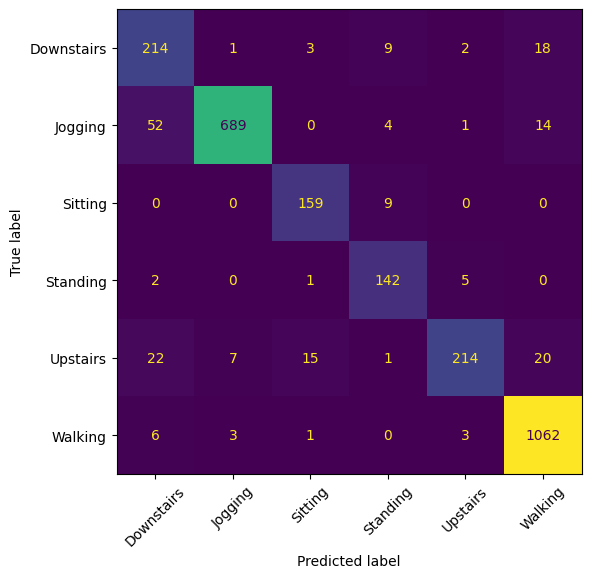

In [50]:
# 12) 혼동행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout(); plt.show()

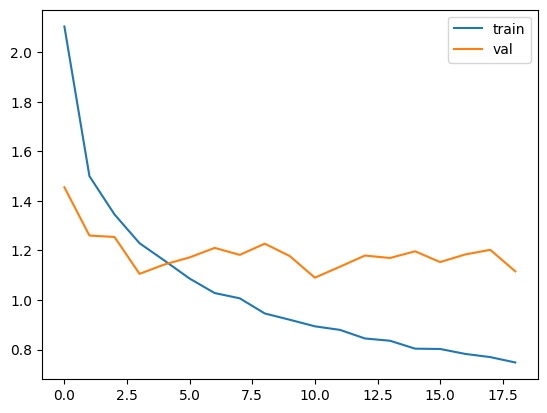

In [52]:
# 13) 학습곡선
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val"); plt.legend(); plt.show()